In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = torch.load("../../../data/preprocessed_data/dataset_155.pt")

/tmp/ipykernel_55328/1568903081.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("../../../data/preprocessed_data/dataset_155.pt")


In [4]:
nf = data['near_fields']
nf.shape

torch.Size([100, 2, 166, 166, 63])

In [32]:
def get_radial_profile(field, rho, radial_bin_edges, num_bins):
    """Computes 1D radial profiles (annular binning) of an input field.
    
    Parameters
    ----------
    field (torch.tensor): Input field of shape [xdim, ydim]
    rho (torch.tensor): Polar rho component
    radial_bin_edges (torch.tensor): binning setup
    num_bins (int): number of bins for the radial profiling.
    """
    H, W = field.shape
    
    # 1. Get spatial amplitude map
    magnitude_maps = torch.abs(field)
    
    # Ensure DC is at center for coordinate calculations:
    mag_maps_shifted = torch.fft.fftshift(magnitude_maps, dim=(-2, -1))
    
    radial_hist = torch.zeros(num_bins, device=field.device)    
    for i in range(num_bins):
        mask = (rho >= radial_bin_edges[i]) & (rho < radial_bin_edges[i+1])
        # summing over (H,W) dims
        radial_hist[i] = torch.sum(mag_maps_shifted * mask, dim=(-2,-1))

    # Normalize
    epsilon = 1e-10
    radial_hist_norm = radial_hist / (torch.sum(radial_hist) + epsilon)
    return radial_hist_norm

def get_angular_profile(field, theta, angle_bin_edges, num_bins):
    """Computes 1D angular profiles of an input field.
    
    Parameters
    ----------
    field (torch.tensor): Input field of shape [xdim, ydim]
    theta (torch.tensor): Polar theta component
    angle_bin_edges (torch.tensor): binning setup
    num_bins (int): number of bins for the angular profiling.
    """
    H, W = field.shape
    
    # 1. Get spatial amplitude map
    magnitude_maps = torch.abs(field)
    
    # Ensure DC is at center for coordinate calculations:
    mag_maps_shifted = torch.fft.fftshift(magnitude_maps, dim=(-2, -1))
    
    angle_hist = torch.zeros(num_bins, device=field.device)
    for i in range(num_bins):
        if i == num_bins - 1:
            mask_angle = (theta >= angle_bin_edges[i]) & (theta <= angle_bin_edges[i+1])
        else:
            mask_angle = (theta >= angle_bin_edges[i]) & (theta < angle_bin_edges[i+1])
        angle_hist[i] = torch.sum(mag_maps_shifted * mask_angle, dim=(-1, -2))
    
    # Normalize
    epsilon = 1e-10
    angle_hist_norm = angle_hist / (torch.sum(angle_hist) + epsilon)
    return angle_hist_norm

def precompute_polar_coordinates(H, W, device):
    y = torch.arange(0, H, device=device, dtype=torch.float32)
    x = torch.arange(0, W, device=device, dtype=torch.float32)
    y_indices, x_indices = torch.meshgrid(y, x, indexing='ij')
    crow, ccol = H // 2, W // 2
    x_coords = x_indices - ccol
    y_coords = y_indices - crow
    rho = torch.sqrt(x_coords**2 + y_coords**2) # (H, W)
    theta = (torch.arctan2(y_coords, x_coords) * 180 / torch.pi) % 360 # (H, W)
    return rho, theta

In [28]:
num_bins = 100

def mse(field1, field2):
    return torch.mean(torch.abs(field1 - field2)**2)

def kMag(field1, field2):
    """k-space magnitude loss. Calculates MSE between magnitudes of k-space fields
    
    Parameters
    ----------
    option (str): calculation method. 'log' if using log transform, 'direct' otherwise.
    """
    field1_k = torch.fft.fft2(field1, norm="ortho")
    field2_k = torch.fft.fft2(field2, norm="ortho")
    mag_f1_k = torch.abs(field1_k)
    mag_f2_k = torch.abs(field2_k)
    return torch.mean((torch.log1p(mag_f1_k) - torch.log1p(mag_f2_k))**2)

def kPhase(field1, field2):
    """k-space phase loss. Calculates MSE of wrapped phase difference between fields
    
    Parameters
    ----------
    option (str): calculation method. 'mag_weight' if weighting by magnitudes, 'direct' otherwise.
    """
    field1_k = torch.fft.fft2(field1, norm="ortho")
    field2_k = torch.fft.fft2(field2, norm="ortho")
    phase_f1_k = torch.angle(field1_k)
    phase_f2_k = torch.angle(field2_k)
    phase_diff = phase_f1_k - phase_f2_k
    wrapped_phase_diff = torch.atan2(torch.sin(phase_diff), torch.cos(phase_diff))
    weights = torch.log1p(torch.abs(field1_k) * torch.abs(field2_k))
    weights = weights / (torch.max(weights) + 1e-8)
    return torch.mean(weights * wrapped_phase_diff**2)

def kRadial(field1, field2):
    """k-space radial loss. Returns the MSE of radial profiles (annular binning) between fields
    
    Parameters
    ----------
    num_bins (int): number of bins for the radial profiling.
    """
    field1_k = torch.fft.fft2(field1, norm="ortho")
    field2_k = torch.fft.fft2(field2, norm="ortho")
    h, w = field1_k.shape
    radial_bin_edges = torch.linspace(0, torch.hypot(torch.tensor(h/2), torch.tensor(w/2)).item(), num_bins + 1, device=field1_k.device)
    polar_coords = precompute_polar_coordinates(h, w, field1_k.device)
    f1_k_radial = get_radial_profile(field1_k, polar_coords[0], radial_bin_edges, num_bins)
    f2_k_radial = get_radial_profile(field2_k, polar_coords[0], radial_bin_edges, num_bins)
    return torch.mean((f1_k_radial.float().to(field1_k.device) - 
                        f2_k_radial.float().to(field1_k.device))**2)

def kAngular(field1, field2):
    """k-space angular loss. Returns the MSE of angular profiles between fields.
    """
    field1_k = torch.fft.fft2(field1, norm="ortho")
    field2_k = torch.fft.fft2(field2, norm="ortho")
    h, w = field1_k.shape
    angle_bin_edges = torch.linspace(0, 360, num_bins + 1, device=field1_k.device)
    polar_coords = precompute_polar_coordinates(h, w, field1_k.device)
    gt_k_angular = get_angular_profile(field1_k, polar_coords[1], angle_bin_edges, num_bins)
    pred_k_angular = get_angular_profile(field2_k, polar_coords[1], angle_bin_edges, num_bins)
    return torch.mean((gt_k_angular.float().to(field1_k.device) - 
                        pred_k_angular.float().to(field1_k.device))**2)

In [39]:
def plot_delta_field_dissimilarity(metrics, field_volume, method="grow"):
    """Plots field slice similarity across a larger field volume with various metrics
    
    Parameters
    ----------
    metrics (List): A list of functions
    field_volume (torch.Tensor): The full (2, 166, 166, 63) field volume (two fields)
    method (str) (Optional): Type of measurement. 'grow' or 'sliding' supported
    """
    real = field_volume[0]
    imag = field_volume[1]
    fields = torch.complex(real, imag) # [166,166,63]
    
    # iterate through to get the values
    for func in metrics:
        vals = []
        if method == "grow":
            for i in range(fields.shape[-1]):
                vals.append(func(fields[:, :, 0], fields[:, :, i]))
        elif method == "sliding":
            for i in range(fields.shape[-1] - 1):
                vals.append(func(fields[:, :, i], fields[:, :, i+1]))
        vals = np.array(vals)
        vals = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
        plt.plot(vals, label=func.__name__)
     
    # plot specs    
    plt.title(f"normalized field volume similarity - method: {method}")
    plt.xlabel("Step")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.show()
    

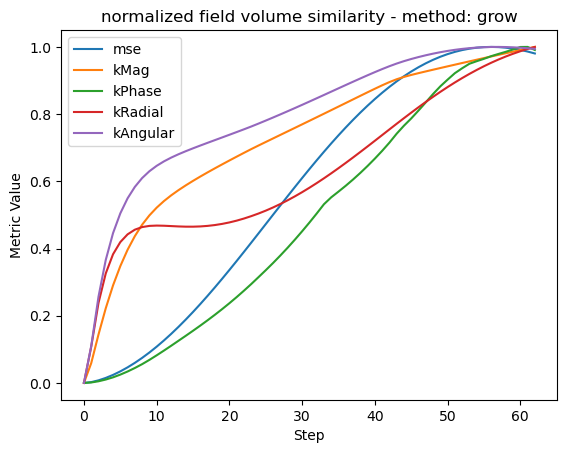

In [45]:
metrics = [mse, kMag, kPhase, kRadial, kAngular]
plot_delta_field_dissimilarity(metrics, nf[0], method="grow")